# Financial Sentiment Analysis and Backtesting
This notebook performs sentiment analysis on financial headlines using FinBERT and VADER, fetches stock data using yfinance, and runs simple trading strategies using Backtrader.

In [10]:
import yfinance as yf
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import backtrader as bt
%matplotlib inline

In [2]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
headlines = [
    "Apple stock rises after strong earnings report",
    "Market turmoil leads to a sharp decline in tech shares",
    "Investors worry about inflation and interest rates",
    "Apple launches new iPhone with innovative features"
]
finbert_results = finbert(headlines)
df_finbert = pd.DataFrame(finbert_results)
df_finbert["headline"] = headlines
df_finbert

Device set to use mps:0


,label,score,headline
0,positive,0.797715,Apple stock rises after strong earnings report
1,negative,0.970138,Market turmoil leads to a sharp decline in tec...
2,negative,0.752078,Investors worry about inflation and interest r...
3,positive,0.739317,Apple launches new iPhone with innovative feat...


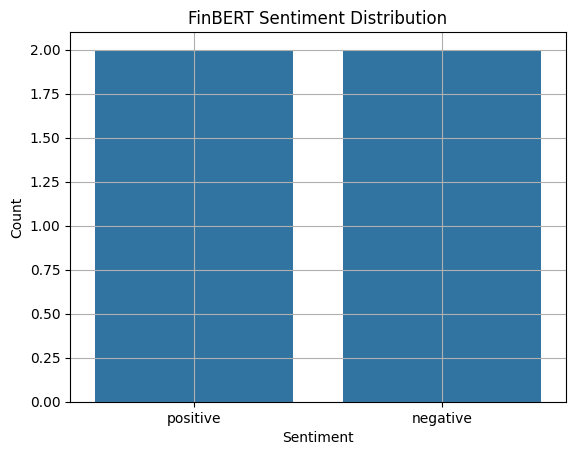

In [3]:
sns.countplot(x='label', data=df_finbert)
plt.title("FinBERT Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [4]:
analyzer = SentimentIntensityAnalyzer()
vader_scores = [analyzer.polarity_scores(h)["compound"] for h in headlines]
df_vader = pd.DataFrame({"headline": headlines, "vader_score": vader_scores})
df_vader

,headline,vader_score
0,Apple stock rises after strong earnings report,0.5106
1,Market turmoil leads to a sharp decline in tec...,-0.0772
2,Investors worry about inflation and interest r...,0.0258
3,Apple launches new iPhone with innovative feat...,0.4404


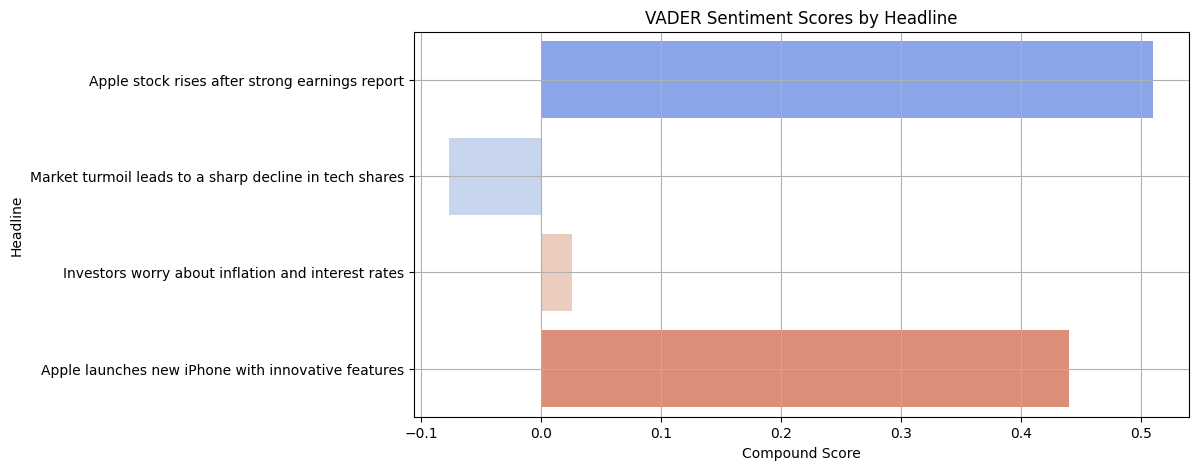

In [5]:
plt.figure(figsize=(10, 5))
sns.barplot(x="vader_score", y="headline", data=df_vader, palette="coolwarm", hue="headline", legend=False)
plt.title("VADER Sentiment Scores by Headline")
plt.xlabel("Compound Score")
plt.ylabel("Headline")
plt.grid(True)
plt.show()

/var/folders/c6/z7pdynp14jd16wp1d1c7cvsc0000gn/T/ipykernel_40634/2125678250.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_stock = yf.download("AAPL", start="2023-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


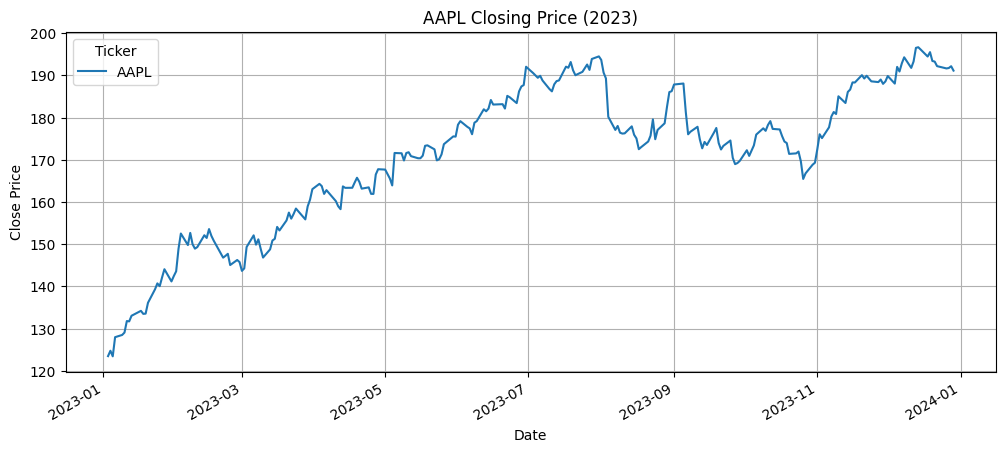

In [7]:
df_stock = yf.download("AAPL", start="2023-01-01", end="2023-12-31")
df_stock["Close"].plot(title="AAPL Closing Price (2023)", figsize=(12, 5))
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

In [9]:
df_stock.columns = df_stock.columns.map(str)
df_stock.index = pd.to_datetime(df_stock.index)
df_stock = df_stock.sort_index()
class TestStrategy(bt.Strategy):
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=15)

    def next(self):
        if self.data.close[0] > self.sma[0]:
            self.buy()
        elif self.data.close[0] < self.sma[0]:
            self.sell()
cerebro = bt.Cerebro()
bt_data = bt.feeds.PandasData(dataname=df_stock)
cerebro.adddata(bt_data)
cerebro.addstrategy(TestStrategy)
print("Backtrader Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
cerebro.run()
print("Backtrader Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

Backtrader Starting Portfolio Value: 10000.00
Backtrader Final Portfolio Value: 10000.00
